# Data Assimilation for Multiscale Systems
The purpose of this tutorial module is to demonstrate ensemble DA for multiscale systems. Using a 2D vortex model as an example, we will explore how the EnKF perform under various scenarios and investigate several multiscale algorithms and compare them to the traditional single-scale method.


## Some preparation
Here we define all the utility functions, the model, and the EnKF filter update function


import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

functions for generating random 2D fields as model states

State variables of the toy model is defined as $u, v$ winds on a 2D uniform grid with cyclic boundary condition. A

Generate model state randomly with prescribed amplitude and spectral power law


add some utility functions to find vorticity and streamfunctions
$$
\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} 
$$


In [2]:
def fft_index(n):
    nup = int(np.ceil((n+1)/2))
    if n%2 == 0:
        wn = np.concatenate((np.arange(0, nup), np.arange(2-nup, 0)))
    else:
        wn = np.concatenate((np.arange(0, nup), np.arange(1-nup, 0)))
    return wn

def random_field(n, power_law):
    pk = lambda k: k**((power_law-1)/2)
    wn = fft_index(n)
    kx, ky = np.meshgrid(wn, wn)
    k2d = np.sqrt(kx**2 + ky**2)
    k2d[np.where(k2d==0.0)] = 1e-10
    noise = np.fft.fft2(np.random.normal(0, 1, (n, n)))
    amplitude = pk(k2d)
    amplitude[np.where(k2d==1e-10)] = 0.0
    noise1 = np.real(np.fft.ifft2(noise * amplitude))
    return (noise1 - np.mean(noise1))/np.std(noise1)

def gen_random_state(ni, nj, nv, dx, vx_amp=3e-3, vx_size=3, loc_sprd=0, bg_amp=1e-4, bg_power_law=-1):
    x = np.zeros((ni, nj, nv))
    zeta = bg_amp * random_field(ni, bg_power_law)  ##background flowd
    ##add vortex near center
    ii, jj = np.mgrid[0:ni, 0:nj]
    center_i = 0.6*ni+np.random.normal(0, loc_sprd)
    center_j = 0.4*nj+np.random.normal(0, loc_sprd)
    zeta += vx_amp * np.exp(-((ii-center_i)**2 + (jj-center_j)**2) / vx_size**2)
    u, v = zeta2uv(zeta, dx)
    x[:, :, 0] = u
    x[:, :, 1] = v
    return x

the model equation:
$$
\frac{\partial \zeta}{\partial t} + v \cdot \nabla \zeta = \rm{gen} \ \zeta + \rm{diss} \ \nabla^2 \zeta
$$

In [14]:
def advance_time(X, dx, dt, smalldt=300, gen=3e-6, diss=1e3):
    u = X[:, :, 0]
    v = X[:, :, 1]
    zeta = uv2zeta(u, v, dx)
    for n in range(int(dt/smalldt)):
        rhs1 = forcing(u, v, zeta, dx, gen, diss)
        zeta1 = zeta + 0.5*smalldt*rhs1
        rhs2 = forcing(u, v, zeta1, dx, gen, diss)
        zeta2 = zeta + 0.5*smalldt*rhs2
        rhs3 = forcing(u, v, zeta2, dx, gen, diss)
        zeta3 = zeta + smalldt*rhs3
        rhs4 = forcing(u, v, zeta3, dx, gen, diss)
        zeta = zeta + smalldt*(rhs1/6.0 + rhs2/3.0 + rhs3/3.0 + rhs4/6.0)
        u, v = zeta2uv(zeta, dx)
    Xt = X.copy()
    Xt[:, :, 0] = u
    Xt[:, :, 1] = v
    return Xt

def forcing(u, v, zeta, dx, gen, diss):
    f = -(u*deriv_x(zeta, dx)+v*deriv_y(zeta, dx)) + gen*zeta + diss*laplacian(zeta, dx)
    return f


def deriv_x(f, dx):
    return (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2.0*dx)

def deriv_y(f, dx):
    return (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2.0*dx)

def laplacian(f, dx):
    return ((np.roll(f, -1, axis=0) + np.roll(f, 1, axis=0) + np.roll(f, -1, axis=1) + np.roll(f, 1, axis=1)) - 4.0*f)/(dx**2)

def psi2uv(psi, dx):
    u = -(np.roll(psi, -1, axis=1) - psi) / dx
    v = (np.roll(psi, -1, axis=0) - psi) / dx
    return u, v

def uv2zeta(u, v, dx):
    zeta = (v - np.roll(v, 1, axis=0) - u + np.roll(u, 1, axis=1))/dx
    return zeta

def psi2zeta(psi, dx):
    return laplacian(psi, dx)

def zeta2psi(zeta, dx):
    psi = np.zeros(zeta.shape)
    niter = 500
    for i in range(niter):
        psi = ((np.roll(psi, -1, axis=0) + np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=1) + np.roll(psi, 1, axis=1)) - zeta*(dx**2))/4.0
    return psi

def zeta2uv(zeta, dx):
    psi = zeta2psi(zeta, dx)
    u, v = psi2uv(psi, dx)
    return u, v


For the DA method, we will use the EnSRF throughout the tutorial. It is a deterministic variant of the EnKF.

In [15]:
def EnSRF(Xb, Yb, Yo, obs_x_intv, obs_err_std, local_cutoff, print_out=False):
    X = Xb.copy()
    ni, nj, nv, nens = Xb.shape
    ##prepare obs
    n_obs = int(np.ceil(ni/obs_x_intv))
    total_n_obs = n_obs*n_obs*nv
    ii, jj, vv = np.mgrid[0:ni:obs_x_intv, 0:nj:obs_x_intv, 0:nv]
    obs = np.reshape(Yo, (total_n_obs,))
    io = np.reshape(ii, (total_n_obs,))
    jo = np.reshape(jj, (total_n_obs,))
    vo = np.reshape(vv, (total_n_obs,))
    for n in range(obs.size):    ###loop over observations to assimilate serially
        yo = obs[n]
        yb = X[int(io[n]), int(jo[n]), int(vo[n]), :]
        yb_mean = np.mean(yb)
        ybp = yb - yb_mean
        varb = np.sum(ybp**2) / (nens - 1)
        varo = obs_err_std**2
        innov = yo - yb_mean
        if print_out: ##print out obs info
            print('obs at ({}, {}, {}) '.format(io[n], jo[n], vo[n]) +
                  'yo={:5.2f} yo_var={:5.2f}, yb_mean={:5.2f}, yb_var={:5.2f}'.format(yo, varo, yb_mean, varb))
        if varb>0 and np.abs(innov)!=0:
            ##loop over state variables within localization radius to update
            for v in range(nv):
                for iz in range(-local_cutoff, local_cutoff+1):
                    for jz in range(-local_cutoff, local_cutoff+1):
                        i = (io[n] + iz) % ni
                        j = (jo[n] + jz) % nj
                        dist = np.sqrt((i-io[n])**2+(j-jo[n])**2)
                        loc = local_GC(dist, local_cutoff)
                        srf = 1.0 / (1.0 + np.sqrt(varo / (varo + varb)))
                        xm = np.mean(X[i, j, v, :])
                        xp = X[i, j, v, :] - xm
                        cov = np.sum(xp * ybp) / (nens - 1)
                        gain = loc * cov / (varo + varb)
                        xm = xm + gain * innov
                        xp = xp - srf * gain * ybp
                        X[i, j, v, :] = xp + xm
    return X

def local_GC(dist, cutoff):
    loc = 1
    if cutoff>0:
        r = dist / (cutoff / 2)
        if dist<cutoff/2:
            loc = (((-0.25*r + 0.5)*r + 0.625)*r - 5.0/3.0) * r**2 + 1
        if dist>=cutoff/2 and dist<cutoff:
            loc = ((((r/12.0 - 0.5)*r + 0.625)*r + 5.0/3.0)*r - 5.0)*r + 4 - 2.0/(3.0*r)
        if dist>=cutoff:
            loc = 0
    else:
        loc = 1
    return loc

def inflation(X, infl):
    Xinf = X.copy()
    ni, nj, nv, nens = X.shape
    Xm = np.mean(X, axis=3)
    for m in range(nens):
        Xinf[:, :, :, m] = infl*(X[:, :, :, m] - Xm) + Xm
    return Xinf

Some performance metric

In [16]:
def rmse(Xens, Xt):
    return np.sqrt(np.mean((np.mean(Xens, axis=3)-Xt)**2, axis=(0,1,2)))

def sprd(Xens):
    return np.sqrt(np.mean(np.std(Xens, axis=3)**2, axis=(0,1,2)))

def sawtooth(out_b, out_a):
    nt = out_b.size
    tt = np.zeros(nt*2)
    tt[0::2] = np.arange(0, nt)
    tt[1::2] = np.arange(0, nt)
    out_st = np.zeros(nt*2)
    out_st[0::2] = out_b
    out_st[1::2] = out_a
    return tt, out_st

2D power spectra $u(x, y)$ defined in model state space and its spectrum $\hat{u}(k)$ in wavenumber (spectral) space 

$u, v$ wind variances are summed to form the kinetic energy $ u^2 + v^2 $ spectrum



In [17]:
def pwr_spec(f):
    ni, nj, nv = f.shape
    fk = np.zeros((ni, nj, nv), dtype=complex)
    nupx = int(np.ceil((ni+1)/2))
    nupy = int(np.ceil((nj+1)/2))
    nup = max(nupx, nupy)
    wnx = fft_index(ni)
    wny = fft_index(nj)
    ky, kx = np.meshgrid(wnx, wny)
    k2d = np.sqrt((kx*(nup/nupx))**2 + (ky*(nup/nupy))**2)
    for z in range(nv):
        fk[:, :, z] = np.fft.fft2(f[:, :, z])
    P = (np.abs(fk)/ni/nj)**2
    wn = np.arange(0.0, nup)
    pwr = np.zeros(nup)
    Ptot = np.mean(P, axis=2)
    for w in range(nup):
        pwr[w] = np.sum(Ptot[np.where(np.ceil(k2d)==w)])
    return wn, pwr

def err_spec(Xens, Xt):
    wn, err_pwr = pwr_spec(np.mean(Xens, axis=3)-Xt)
    return wn, err_pwr

def sprd_spec(Xens):
    ni, nj, nv, nens = Xens.shape
    Xmean = np.mean(Xens, axis=3)
    nup = int(np.ceil((ni+1)/2))
    pwr_ens = np.zeros((nup, nens))
    for m in range(nens):
        wn, pwr_ens[:, m] = pwr_spec(Xens[:, :, :, m] - Xmean)
    sprd_pwr = np.sum(pwr_ens, axis=1) / (nens-1)
    return wn, sprd_pwr

function that calculate the scale component of a given spatial field, using the pyramid method

In [18]:
def get_scale(x, scales, s):
    ns = len(scales)
    xs = coarsen(x, 1, scales[s])
    if s > 0:
        xc = coarsen(x, 1, scales[s-1])
        xcs = sharpen(xc, scales[s-1], scales[s])
        xs -= xcs
    return xs

Some functions for alignment techniques

In [19]:
def optical_flow(x1in, x2in, nlevel, w=100):
    x1 = x1in.copy()
    x2 = x2in.copy()
    ni, nj, nv, nens = x1.shape
    u = np.zeros((ni, nj, nv, nens))
    v = np.zeros((ni, nj, nv, nens))
    ###pyramid levels
    for lev in range(nlevel, -1, -1):
        x1w = warp(x1, -u, -v)
        x1c = coarsen(x1w, 1, lev)
        x2c = coarsen(x2, 1, lev)
        niter = 1000
        xdx = 0.5*(deriv_x(x1c, 1) + deriv_x(x2c, 1))
        xdy = 0.5*(deriv_y(x1c, 1) + deriv_y(x2c, 1))
        xdt = x2c - x1c
        ###compute incremental flow using iterative solver
        du = np.zeros(xdx.shape)
        dv = np.zeros(xdx.shape)
        for k in range(niter):
            ubar = laplacian2(du) + du
            vbar = laplacian2(dv) + dv
            du = ubar - xdx*(xdx*ubar + xdy*vbar + xdt)/(w + xdx**2 + xdy**2)
            dv = vbar - xdy*(xdx*ubar + xdy*vbar + xdt)/(w + xdx**2 + xdy**2)
        u += sharpen(du*2**lev, lev, 1)
        v += sharpen(dv*2**lev, lev, 1)
    return u, v

def laplacian2(f):
    return ((np.roll(f, -1, axis=0) + np.roll(f, 1, axis=0) + np.roll(f, -1, axis=1) + np.roll(f, 1, axis=1))/6. + 
            (np.roll(np.roll(f, -1, axis=1), -1, axis=0) + np.roll(np.roll(f, -1, axis=1), 1, axis=0) + 
             np.roll(np.roll(f, 1, axis=1), -1, axis=0) + np.roll(np.roll(f, 1, axis=1), 1, axis=0))/12. - f)


def warp(x, u, v):
    xw = x.copy()
    ni, nj, nv, nens = x.shape
    ii, jj, vv, mm = np.mgrid[0:ni, 0:nj, 0:nv, 0:nens]
    xw = interp2d(x, ii+u, jj+v, vv, mm)
    return xw

def interp2d(x, io, jo, vv, mm):
    ni, nj, nv, nens = x.shape
    io1 = np.floor(io).astype(int) % ni
    jo1 = np.floor(jo).astype(int) % nj
    io2 = np.floor(io+1).astype(int) % ni
    jo2 = np.floor(jo+1).astype(int) % nj
    di = io - np.floor(io)
    dj = jo - np.floor(jo)
    xo = (1-di)*(1-dj)*x[io1, jo1, vv, mm] + di*(1-dj)*x[io2, jo1, vv, mm] + (1-di)*dj*x[io1, jo2, vv, mm] + di*dj*x[io2, jo2, vv, mm]
    return xo

def coarsen(xi, lev1, lev2):
    x = xi.copy()
    if lev1 < lev2:
        for k in range(lev1, lev2):
            ni, nj = x.shape[0:2]
            x1 = 0.25*(x[0::2, 0::2]+x[0::2, 1::2]+x[1::2, 0::2]+x[1::2, 1::2])
            x = x1
    return x

def sharpen(xi, lev1, lev2):
    x = xi.copy()
    if lev1 > lev2:
        for k in range(lev1, lev2, -1):
            dim = list(x.shape)
            dim[0] = dim[0]*2
            x1 = np.zeros(dim)
            x1[0:dim[0]:2, :] = x
            x1[1:dim[0]:2, :] = 0.5*(np.roll(x, -1, axis=0) + x)
            dim[1] = dim[1]*2
            x2 = np.zeros(dim)
            x2[:, 0:dim[1]:2] = x1
            x2[:, 1:dim[1]:2] = 0.5*(np.roll(x1, -1, axis=1) + x1)
            x = x2
    return x

wrapper function for calculating filter update in multiscale framework

In [20]:
def filter_update(Xb, Yo, obs_x_intv, obs_err_std, local_cutoff, infl=1.0, scales=(1,), run_alignment=False):
    X = Xb.copy()
    X = inflation(X, infl)
    ni, nj, nv, nens = Xb.shape
    ns = len(scales)

    for s in range(ns):
        print('   process scale {}'.format(s+1))
        Xbs = get_scale(X, scales, s)
        Yos = get_scale(Yo, scales, s)

        Xas = EnSRF(Xbs, Yos, obs_x_intv, obs_err_std[s], local_cutoff[s])

        if s < ns-1 and run_alignment:
            print('      run alignment')
            us, vs = optical_flow(Xbs, Xas, nlevel=6-scales[s], w=500)
            Xbsw = warp(Xbs, -us, -vs)
            u = sharpen(us * 2**(scales[s]-1), scales[s], 1)
            v = sharpen(vs * 2**(scales[s]-1), scales[s], 1)
            X = warp(X, -u, -v)  ##displacement adjustment
            X += sharpen(Xas - Xbsw, scales[s], 1)  ##amplitude adjustment
        else:
            X += sharpen(Xas - Xbs, scales[s], 1)

    return X

## Get to know the spectral space

Let's take a look at different spatial fields and their corresponding 2D spectra $\hat{A}(k), k=\sqrt{k_x^2+k_y^2}$

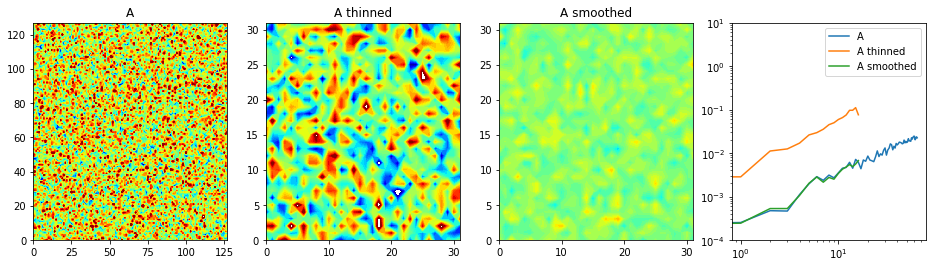

In [21]:
n = 128
power_law = 1
err_std = 1
A = np.zeros((n, n, 1))
A[:, :, 0] = random_field(n, power_law)
At = A[::4, ::4, :]
Ac = coarsen(A, 1, 3)

plt.figure(figsize=(16,4))
ax = plt.subplot(1,4,1)
ax.contourf(A[:, :, 0], np.arange(-2, 2, 0.1), cmap='jet')
ax.set_title('A')
ax = plt.subplot(1,4,2)
ax.contourf(At[:, :, 0], np.arange(-2, 2, 0.1), cmap='jet')
ax.set_title('A thinned')
ax = plt.subplot(1,4,3)
ax.contourf(Ac[:, :, 0], np.arange(-2, 2, 0.1), cmap='jet')
ax.set_title('A smoothed')
ax = plt.subplot(1,4,4)
wn, pwr = pwr_spec(A)
ax.loglog(wn, pwr, label='A')
wn, pwr = pwr_spec(At)
ax.loglog(wn, pwr, label='A thinned')
wn, pwr = pwr_spec(Ac)
ax.loglog(wn, pwr, label='A smoothed')
ax.set_ylim([1e-4, 10])
ax.legend()

The model state looks like this

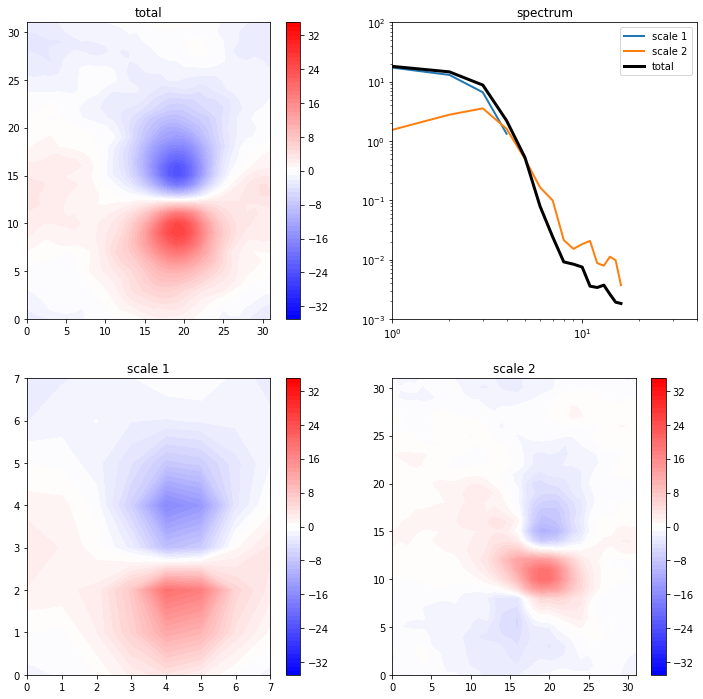

In [22]:
Xout = gen_random_state(32, 32, 2, dx=10000)

scales = (3, 1)
ni, nj, nv = Xout.shape
ns = len(scales)
Xsc = np.zeros((ni, nj, nv, ns))

plt.figure(figsize=(12,12))
ax = plt.subplot(2,2,1)
c = ax.contourf(Xout[:, :, 0].T, np.arange(-35, 36), cmap='bwr')
plt.colorbar(c)
ax.set_title('total')
ax1 = plt.subplot(2,2,2)
for s in range(ns):
    Xs = get_scale(Xout, scales, s)
    wn, pwr = pwr_spec(Xs)
    ax = plt.subplot(2,2,s+3)
    c = ax.contourf(Xs[:, :, 0].T, np.arange(-35, 36), cmap='bwr')
    plt.colorbar(c)
    ax.set_title('scale {}'.format(s+1))
    ax1.loglog(wn, pwr, linewidth=2, label='scale {}'.format(s+1))
wn, pwr = pwr_spec(Xout)
ax1.loglog(wn, pwr, color='black', linewidth=3, label='total')
ax1.set_xlim([1, 40])
ax1.set_ylim([1e-3, 1e2])
ax1.set_title('spectrum')
ax1.legend()

## Run cycling experiments and evaluate filter performance

This part runs cycling DA experiments and plot the results. To try a certain configuration, change the parameter here and run the whole part.

In [26]:
np.random.seed(100) #seed fixed so results are reproducible

##model parameter
ni, nj, nv = (32, 32, 2)  ##state dimensions, ni=nj=2**level
dx = 10000  ##grid spacing (km)
dt = 3600   ##cycle period, time step (sec)

##obs network config
obs_x_intv = 4  ##spatial density
obs_t_intv = 1  ##temporal frequency
obs_err_std = 3. ##measurement error
obs_err_power_law = 1  ##1: white noise (uncorrelated errors)
nt = 12

##filter config
run_filter = False
nens = 20                      ##ensemble size
scales = np.array([1])         ###number of scales defined in pyramid levels
local_cutoff = np.array([3])  ##localization cutoff distance (number of grid points)
obs_err_infl = np.array([1])   ##obs error inflation
run_alignment = False          ##run alignment step if true

Perform cycling DA experiment here:

In [31]:
Xt = np.zeros((ni, nj, nv, nt+1))
Xt[:, :, :, 0] = gen_random_state(ni, nj, nv, dx)
for t in range(nt):
    Xt[:, :, :, t+1] = advance_time(Xt[:, :, :, t], dx, dt)

##initial ensemble 
Xb = np.zeros((ni, nj, nv, nens, nt+1))
for m in range(nens):
    Xb[:, :, :, m, 0] = gen_random_state(ni, nj, nv, dx)

##generate obs
n_obs = int(np.ceil(ni/obs_x_intv))
Yo = np.zeros((n_obs, n_obs, nv, nt+1))
for t in range(nt):
    if t%obs_t_intv==0:
        for k in range(nv):
            Yo[:, :, k, t] = Xt[::obs_x_intv, ::obs_x_intv, k, t] + obs_err_std * random_field(n_obs, obs_err_power_law)

X = Xb.copy()   ##posterior ensemble

##start cycling
for t in range(nt):
    X[:, :, :, :, t] = Xb[:, :, :, :, t]

    if t>0 and t%obs_t_intv==0 and run_filter:
        print('running EnSRF for t={}'.format(t))
        X[:, :, :, :, t] = filter_update(X[:, :, :, :, t], Yo[:, :, :, t], obs_x_intv, 
                                         obs_err_std*obs_err_infl, local_cutoff, 1.,
                                         scales, run_alignment)
    
    print('running forcast t={}'.format(t))
    Xb[:, :, :, :, t+1] = advance_time(X[:, :, :, :, t], dx, dt)

running forcast t=0
running forcast t=1
running forcast t=2
running forcast t=3
running forcast t=4
running forcast t=5
running forcast t=6
running forcast t=7
running forcast t=8
running forcast t=9
running forcast t=10
running forcast t=11


let's visualize the results:

we plot u wind maps and highlight a pair of contours in black, the ensemble members have slight differences against the truth, they are shown in colors (spaghetti plot). We also show error spectra and domain averaged error time series.

In [34]:
def plot_summary(t):
    ##panel 1: true u wind maps
    ax[0].clear()
    u_contour = (-15, 15)  ##highlight these contours
    c = ax[0].contourf(Xt[:, :, 0, t].T, np.arange(-30, 31), cmap='bwr')
    ax[0].contour(Xt[:, :, 0, t].T, u_contour, colors='black', linewidths=3)
    ax[0].set_title('true u wind t={}h'.format(t))
    
    ##panel 2: ensemble spaghetti plots of highlighted contours
    ax[1].clear()
    cmap = [plt.cm.jet(x) for x in np.linspace(0, 1,nens)]
    for m in range(nens):
        ax[1].contour(X[:, :, 0, m, t].T, u_contour, colors=[cmap[m][0:3]])
    ax[1].contour(Xt[:, :, 0, t].T, u_contour, colors='black', linewidths=3)
    ax[1].set_title('ensemble spaghetti t={}h'.format(t))

    ##panel 3: power spectra
    ax[2].clear()
    wn, pwr = pwr_spec(Xt[:, :, :, t])
    ax[2].loglog(wn, pwr, color='black', linewidth=3, label='truth')
    wn, err_pwr = err_spec(X[:, :, :, :, t], Xt[:, :, :, t])
    ax[2].loglog(wn, err_pwr, color='red', linewidth=3, label='error')
    wn, sprd_pwr = sprd_spec(X[:, :, :, :, t])
    ax[2].loglog(wn, sprd_pwr, color='red', linestyle=':', linewidth=2, label='sprd')
    ax[2].legend()
    ax[2].set_title('power spectrum t={}h'.format(t))
    ax[2].set_ylim([1e-3, 1e2])

    ##panel 4: sawtooth graph (error time series)
    ax[3].clear()
    tt, rmse_st = sawtooth(rmse(Xb, Xt), rmse(X, Xt))
    tt, sprd_st = sawtooth(sprd(Xb), sprd(X))
    ax[3].plot(tt[0:2*t+1], rmse_st[0:2*t+1], color='red', linewidth=3)
    ax[3].plot(tt[0:2*t+1], sprd_st[0:2*t+1], color='red', linestyle=':', linewidth=2)
    ax[3].set_title('domain-avg rmse,sprd')
    ax[3].set_xlim([0, nt])
    ax[3].set_ylim([0, 5])
    ax[3].set_xlabel('t')
    return c

fig, ax = plt.subplots(1, 4, figsize=(20,5))
plt.rcParams.update({'font.size': 14})
plt.close()
anim = animation.FuncAnimation(fig, plot_summary, frames=nt, interval=300)
HTML(anim.to_html5_video())

plot summary of DA outcome in both physical and spectral space

Text(0.5, 1.0, 'post error')

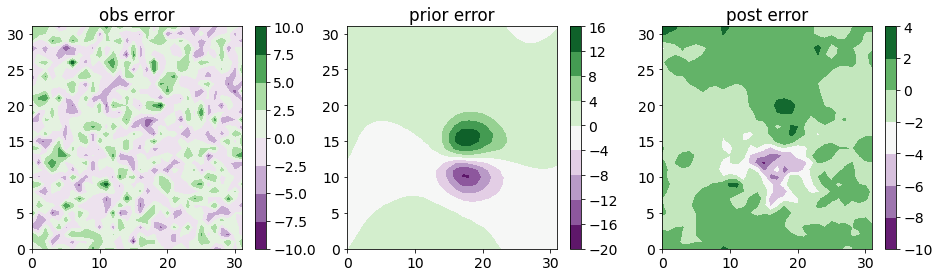

In [ ]:
t = 1
obs_err = Yo[:, :, :, t]- Xt[::obs_x_intv, ::obs_x_intv, :, t]
prior_err = np.mean(Xb[:, :, :, :, t], axis=3) - Xt[:, :, :, t]
post_err = np.mean(X[:, :, :, :, t], axis=3) - Xt[:, :, :, t]

plt.figure(figsize=(16,9))
ax = plt.subplot(231)
c = ax.contourf(obs_err[:, :, 0].T, cmap='PRGn')
plt.colorbar(c)
ax.set_title('obs error')

ax = plt.subplot(232)
c = ax.contourf(prior_err[:, :, 0].T, cmap='PRGn')
plt.colorbar(c)
ax.set_title('prior error')

ax = plt.subplot(233)
c = ax.contourf(post_err[:, :, 0].T, cmap='PRGn')
plt.colorbar(c)
ax.set_title('post error')

Text(0.5, 1.0, 'spectrum')

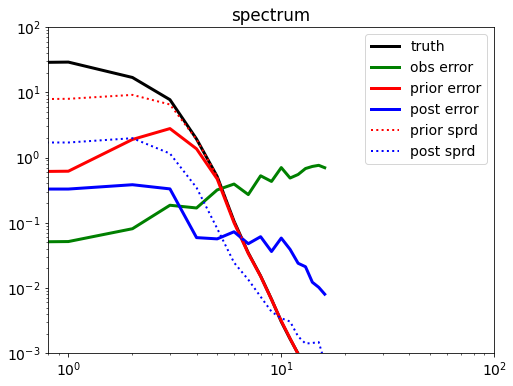

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
wn, pwr = pwr_spec(Xt[:, :, :, t])
ax.loglog(wn, pwr, color='black', linewidth=3, label='truth')
wn, pwr = pwr_spec(obs_err)
ax.loglog(wn, pwr, color='green', linewidth=3, label='obs error')
wn, pwr = pwr_spec(prior_err)
ax.loglog(wn, pwr, color='red', linewidth=3, label='prior error')
wn, pwr = pwr_spec(post_err)
ax.loglog(wn, pwr, color='blue', linewidth=3, label='post error')
wn, pwr = sprd_spec(Xb[:, :, :, :, t])
ax.loglog(wn, pwr, color='red', linewidth=2, linestyle=':', label='prior sprd')
wn, pwr = sprd_spec(X[:, :, :, :, t])
ax.loglog(wn, pwr, color='blue', linewidth=2, linestyle=':', label='post sprd')
ax.set_xlim([0.8, 100])
ax.set_ylim([1e-3, 1e2])
ax.legend()
ax.set_title('spectrum')

**Tuning station:**

to tune a parameter for optimal performance, we can fix other parameters and try a range of values and see the output metric behavior, the lowest rmse e.g. will give the best parameter.

testing param = 1
   process scale 1
testing param = 2
   process scale 1
testing param = 3
   process scale 1
testing param = 4
   process scale 1
testing param = 6
   process scale 1
testing param = 8
   process scale 1
testing param = 10
   process scale 1


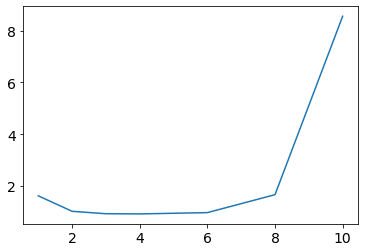

In [ ]:
params = (1, 2, 3, 4, 6, 8) ##for localization
#params = (10, 20, 40)
rmse_out = np.zeros(len(params))
for p in range(len(params)):
    print('testing param = {}'.format(params[p]))

    obs_x_intv = 4
    obs_err_std = 1
    obs_err_power_law = 1
    nens = 20
    run_alignment = False
    scales = np.array([1])
    local_cutoff = np.array([params[p]*obs_x_intv])
    obs_err_infl = np.array([1])

    n_obs = int(np.ceil(ni/obs_x_intv))
    Yo = np.zeros((n_obs, n_obs, nv))
    for k in range(nv):
        Yo[:, :, k] = Xt[::obs_x_intv, ::obs_x_intv, k, 0] + obs_err_std * random_field(n_obs, obs_err_power_law)
    Xa = filter_update(Xb[:, :, :, 0:nens, 0], Yo, obs_x_intv, obs_err_std*obs_err_infl, local_cutoff, 1., scales, run_alignment)
    rmse_out[p] = rmse(Xa, Xt[:, :, :, 0])
plt.figure()
plt.plot(params, rmse_out)